#  
## Part 2. Developing Machine Learning Model

> Author: **Chloe Jung** <br>
> Date Finished:

## Table of Contents

The data was obtained from [Kaggle](https://www.kaggle.com/lava18/google-play-store-apps).

* [1. Import the Packages](#ImportPackages)
* [2. Load the Data](#LoadData)
* [3. Preprocessing](#Preprocessing)
    * [3-1. Impute the Missing Values](#Impute)
    * [3-2. Integer Encoding](#IntegerEncoding)
    * [3-3. Dummy Variable](#DummyVariable)
* [4. Set Up Evaluation Matrix](#EvalMat)
* [5. Explore Different Models](#Explore)
* [6. Model Comparison](#ModelComparison)
* [7. Hyperparameter Tuning](#HyperparameterTuning)
    * [7-1. Random Search](#RandomSearch)
    * [7-2. Grid Search](#GridSearch)
* [8. Feature Importance](#FeatureImportance)

### Feedback:
1. Have a better understanding of features which will be used in the model: 1. what they are, make it an explicit list, distributions are in EDA, right? please make sure you distinguish numerical and categorical features.   

2. For Tree based models, there is no need to scale the data, this in fct can play a negative role. You can for logistic regression. 

3. Include lift metric - this is a very useful metric for these kinds of problems. 

4.  What does the ROC curve look like for these models?

5.  Which best parameters came out from the grid search? List them explicitly. 

6. What is the conclusion, which model works the best? What metric would you use to quantify? I would suggest use lift, other metric can be used too (recall, for example)

7. How do the probability distributions different among these models? I mean the probability for positive class (second element from the predic_proba)


## 1. Import Packages <a class="anchor" id="ImportPackages"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import __version__ as sklearn_version
from sklearn import metrics, svm
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, train_test_split, RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score, r2_score, mean_squared_error, mean_absolute_error, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, recall_score, precision_recall_curve
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn import datasets
import xgboost as xgb
import catboost as ctb

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, scale, StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier, cv, DMatrix
import xgboost as xgb
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV, GridSearchCV, learning_curve, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.feature_selection import SelectKBest

import warnings
warnings.filterwarnings("ignore")

## 2. Load the Data <a class="anchor" id="LoadData"></a>

In [4]:
data = pd.read_csv("bank-additional-full.csv", delimiter=';')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

## 3. Preprocessing <a class="anchor" id="Preprocessing"></a>

In [6]:
int_col = data.dtypes[data.dtypes == 'int64'].index | data.dtypes[data.dtypes == 'float64'].index

In [7]:
obj_col = data.dtypes[data.dtypes == 'object'].index

### Drop duration 
-  this attribute highly affects the output target (e.g., ifduration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known.Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [8]:
df = data.copy()
df.shape

(41188, 21)

In [9]:
df = df.drop(['duration'],axis=1)
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [10]:
df.shape

(41188, 20)

In [11]:
data['housing'].value_counts()

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

### Convert the "object" variables into numeric 

In [12]:
obj_col

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

#### Catecorical Variables: 
##### Binary (yes, no, unknown)
- 'default', 'housing', 'loan'

##### Binary (success, failure, unknown)
- 'poutcome'

#### Ordinal
- 'month', 'day_of_week'

#### Nominal
- 'job', 'marital', 'education', 'contact'

#### Target variable: y

In [13]:
df['y'] = df.y.apply(lambda x:0 if x=='no' else 1)
df['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

##### Binary (yes, no, unknown)
####  1) Label Binary Variables

In [14]:
binary = ['default', 'housing', 'loan']
#creating binary map
bin_map = {'yes': 1, 'no': 0, 'unknown':-1}

#creating new labelled columns
for i in binary:
    df[i] = df[i].map(bin_map)

In [15]:
#creating binary map
bin_map_alt = {'success': 1, 'failure': 0, 'nonexistent':-1}

#creating new labelled columns
df['poutcome'] = df['poutcome'].map(bin_map_alt)

#### 2) Label Ordinal Variable

In [16]:
month_map = {'mar': 3,
            'apr':4,
            'may':5,
            'jun':6,
            'jul':7,
            'aug':8,
            'sep':9,
            'oct':10,
            'nov':11,
            'dec':12}
df['month'] = df['month'].map(month_map)

#### 3) Label Nominal Variable: One Hot Encoding - Dummy Variable


In [17]:
dum_features = ['job', 'marital', 'education', 'contact', 'day_of_week']
df = pd.get_dummies(df,
                     columns=dum_features,
                     drop_first=True) #drop the first column to resolve multicollinearity problem

In [18]:
df.shape

(41188, 41)

In [19]:
# Make sure that there is no missing value
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
age,0,0.0
job_services,0,0.0
job_technician,0,0.0
job_unemployed,0,0.0
job_unknown,0,0.0
marital_married,0,0.0
marital_single,0,0.0
marital_unknown,0,0.0
education_basic.6y,0,0.0
education_basic.9y,0,0.0


## 5. Explore Different Models <a class="anchor" id="EvalMat"></a>

In [20]:
# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Metrics
from sklearn.model_selection import  GridSearchCV
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")

### Train Test Split

In [21]:
seed = 123

X = df.drop('y',axis=1)
y = df['y']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3, 
                                                    random_state = seed)

In [23]:
print("X_train shape:", X_train.shape, "| X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape, "| y_test shape:", y_test.shape)
print("y_train mean:", np.mean(y_train), "| y_test mean:", np.mean(y_test,))

X_train shape: (28831, 40) | X_test shape: (12357, 40)
y_train shape: (28831,) | y_test shape: (12357,)
y_train mean: 0.11251777600499463 | y_test mean: 0.11297240430525209


### k-fold

In [24]:
seed = 123
k = 10

kfolds = model_selection.StratifiedKFold(n_splits=k, shuffle = True, random_state=seed)
kfolds

StratifiedKFold(n_splits=10, random_state=123, shuffle=True)

### Binary Classification:
- Logistic Regression
- k-Nearest Neighbors
- Decision Trees
- Random Forest
- Support Vector Machine
- Gaussian Naive Bayes
- XGBoost

In [25]:
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC

models =[LogisticRegression(),
        KNeighborsClassifier(),
        DecisionTreeClassifier(random_state=seed),
        RandomForestClassifier(random_state=seed),
        GaussianNB(),
        GradientBoostingClassifier(),
        XGBClassifier()]
names = ['LR','KNN','CART','RF','NB','GB','XGB']
model_dict = dict(zip(names,models))

#### Evalulation Metrics:
- Accuracy: (TP+TN)/(TP+TN+FP+FN)
- Precision: TP/(TP+FP)
- Recall (= Sensitivity): TP/(TP+FN)
- F1 Score:
    - Weighted average of Precision and Recall
- Area under the ROC (Received Operating Characteristic) curve (= AUC-ROC)
    - ROC: probability curve
    - AUC: degree or measure of separability (Higher AUC, better the model is distinguishing 0s and 1s)
    

##### Function to train model with n fold cross validation

In [26]:
def model_eval(models, n):
    scores = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'roc_auc' : make_scorer(roc_auc_score, needs_proba=True)}
    kfold = KFold(n_splits=n)
    model = models
    model_result = model_selection.cross_validate(estimator=model,
                                                  X=X_train,
                                                  y=y_train,
                                                  cv=kfold,
                                                  scoring=scores) 
    result = pd.DataFrame(model_result).round(2)
    return result

##### Function to test result for all models

In [27]:
def model_perform(n, model_eval):
    model_score_average = []
    for model in model_dict.values():
        model_score_average.append(model_eval(model, n).mean())
    df_model_eval = pd.DataFrame(model_score_average,index=list(model_dict.keys())).round(3)
    df_model_eval = df_model_eval.reset_index().rename(columns={'index':'model'})
    return df_model_eval

#### Baseline Model Evaluation

In [28]:
model_result = model_perform(3, model_eval)
model_result

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc
0,LR,0.523,0.060,0.897,0.690,0.183,0.293,0.760
1,KNN,0.027,19.030,0.887,0.510,0.280,0.360,0.730
2,CART,0.373,0.070,0.837,0.297,0.330,0.313,0.617
3,RF,5.223,1.160,0.893,0.547,0.287,0.373,0.773
4,NB,0.053,0.090,0.830,0.327,0.477,0.390,0.753
5,GB,7.550,0.127,0.900,0.647,0.233,0.340,0.793
6,XGB,3.337,0.180,0.897,0.580,0.283,0.380,0.780


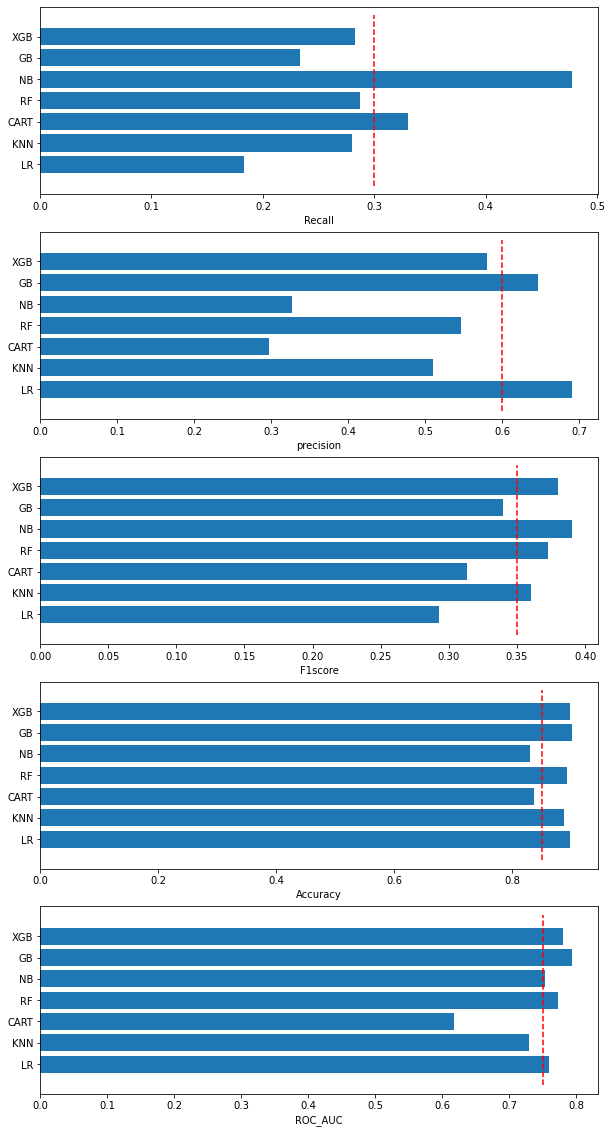

In [29]:
# plot barh plot to check the average score of recall, fscore, accuracy, roc_auc from cross validation
fig,axs = plt.subplots(5,1, figsize=(10,20))

# Recall
axs[0].barh('model', 'test_recall', data=model_result)
axs[0].set_xlabel('Recall')
axs[0].plot([0.3,0.3],[-1,7],'r--')

# precision
axs[1].barh('model', 'test_precision', data=model_result)
axs[1].set_xlabel('precision')
axs[1].plot([0.6,0.6],[-1,7],'r--')

# f1 Score
axs[2].barh('model', 'test_f1_score', data=model_result)
axs[2].set_xlabel('F1score')
axs[2].plot([0.35,0.35],[-1,7],'r--')

# Accuracy
axs[3].barh('model', 'test_accuracy', data=model_result)
axs[3].set_xlabel('Accuracy')
axs[3].plot([0.85,0.85],[-1,7],'r--')

# ROC AUC
axs[4].barh('model', 'test_roc_auc',data=model_result)
axs[4].set_xlabel('ROC_AUC')
axs[4].plot([0.75,0.75],[-1,7],'r--')

plt.savefig('image/_4_baselineModelEval.png',bbox_inches = 'tight')
plt.show()


##### Based on this, the output LR, KNN, RF and XGBClassifier outperformed the other models.

#### Evaluation Matrix

In [30]:
def Evaluationmatrix(y_true, y_predict):
    print('Accuracy Score:', round(accuracy_score(y_test,yhat),2))
    print('Precision Score:', round(precision_score(y_test,yhat),2))
    print('Recall Score:', round(recall_score(y_test,yhat),2))
    print('CV Score:', round(cross_val_score(model, X_train_s, y_train, cv=kfolds, n_jobs=1, scoring = 'accuracy').mean(),2))

In [31]:
#to add into results_index for evaluation of error term 
def Evaluationmatrix_dict(y_true, y_predict, name = 'Linear - Integer'):
    dict_matrix = {}
    dict_matrix['Model'] = name
    dict_matrix['Accuracy Score'] = round(accuracy_score(y_test,yhat),3)
    dict_matrix['Precision Score'] = round(precision_score(y_test,yhat),3)
    dict_matrix['Recall Score'] = round(recall_score(y_test,yhat),3)
    dict_matrix['CV Score'] = round(cross_val_score(model, X, y, cv=kfolds, n_jobs=1, scoring = 'accuracy').mean(),3)
    dict_matrix['ROC AUC'] = round(roc_auc_score(y_test,yhat),3)
    dict_matrix['F1 Score'] = round(f1_score(y_test,yhat),3)
    return dict_matrix

In [32]:
results = pd.DataFrame()

### 5-1. Logistic Regression
- use the scaled data

#### Scale the data

- StandardScaler(): 
    - Assumes that the data is normally distributed
    - Rescales the variables so that the distribution centers around 0 with standard deviation of 1
    - Influence of outliers - does not guarantee balanced feature scales when there are outliers 
- MinMaxScaler(): 
    - Rescales the variables so that all the values are in the same range of 0 to 1
    - Less influenced by outliers, but pushes all inliers in a narrow range
    
- For tree-based models, no need to use the scaled data

In [33]:
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [34]:
model = LogisticRegression(random_state=seed)
model.fit(X_train_s,y_train)
yhat=model.predict(X_test_s)

In [35]:
results = results.append(Evaluationmatrix_dict(y_test,yhat,name="LR"),ignore_index = True)

In [36]:
print(confusion_matrix(y_test,yhat))
print(classification_report(y_test,yhat))
print('Accuracy Score:', round(accuracy_score(y_test,yhat),2))
print('Precision Score:', round(precision_score(y_test,yhat),2))
print('Recall Score:', round(recall_score(y_test,yhat),2))
#print('CV Score:', round(cross_val_score(model, X_train_s, y_train, cv=kfolds, n_jobs=1, scoring = 'accuracy').mean(),2))

[[10827   134]
 [ 1088   308]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10961
           1       0.70      0.22      0.34      1396

    accuracy                           0.90     12357
   macro avg       0.80      0.60      0.64     12357
weighted avg       0.88      0.90      0.88     12357

Accuracy Score: 0.9
Precision Score: 0.7
Recall Score: 0.22


- ROC Curve vs. Precision-Recall Curves
    - ROC: roughly equal number of observations for each class
    - Precision-Recall: moderate to large class imbalance

- ROC Curve:
    - Diagnostic tools that help with interpretation of probabilistic forecast for binary classification
    - AUC: Area Under the Curve, summary if the skill of model.
    - Small values on x-axis: Low false positives, high true negatives
    - Large values on y-axis: High true positives, low false negatives

Source: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.786


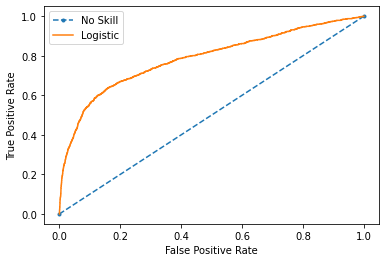

In [37]:
# no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = model.predict_proba(X_test_s)
lr_probs = lr_probs[:, 1] #probabilities for the positive outcome only

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', marker='.', label='No Skill')
plt.plot(lr_fpr, lr_tpr, label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.savefig('image/_5_Base-LR.png',bbox_inches = 'tight')
plt.show()

In [38]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)

### 5-2. Random Forest 

In [39]:
model = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10, random_state=seed)
model.fit(X_train, y_train)
yhat=model.predict(X_test)

In [40]:
results = results.append(Evaluationmatrix_dict(y_test,yhat,name="RF"),ignore_index = True)

In [41]:
print(confusion_matrix(y_test,yhat))
print(classification_report(y_test,yhat))
print('Accuracy Score:', round(accuracy_score(y_test,yhat),2))
print('Precision Score:', round(precision_score(y_test,yhat),2))
print('Recall Score:', round(recall_score(y_test,yhat),2))
print('CV Score:', round(cross_val_score(model, X_train, y_train, cv=kfolds, n_jobs=1, scoring = 'accuracy').mean(),2))

[[10683   278]
 [  977   419]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     10961
           1       0.60      0.30      0.40      1396

    accuracy                           0.90     12357
   macro avg       0.76      0.64      0.67     12357
weighted avg       0.88      0.90      0.88     12357

Accuracy Score: 0.9
Precision Score: 0.6
Recall Score: 0.3
CV Score: 0.9


No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.785


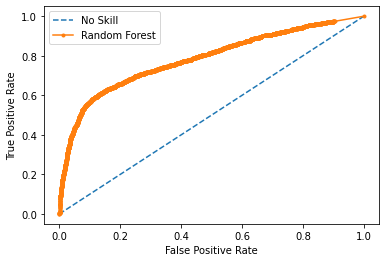

In [42]:
# predict probabilities
rf_probs = model.predict_proba(X_test)
rf_probs = rf_probs[:, 1] #probabilities for the positive outcome only

# calculate scores
rf_auc = roc_auc_score(y_test, rf_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))

# calculate roc curves
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.savefig('image/_6_base-RF.png',bbox_inches = 'tight')
plt.show()

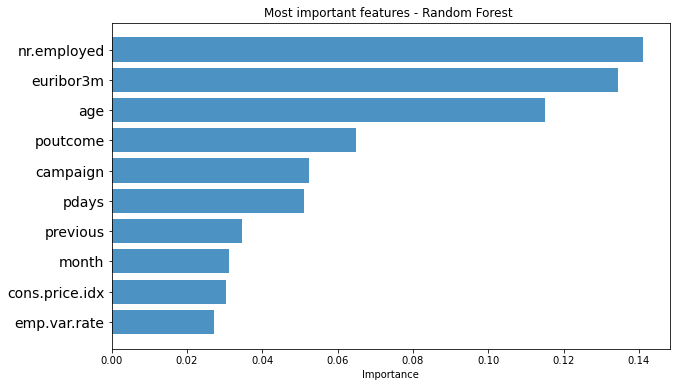

In [43]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = model.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest ')
plt.show()

### Random Forest

RF = RandomForestClassifier()

params = {
    "n_estimators": np.array([50, 100, 200, 300]), 
    "max_depth": [3, 6, 9, 12, 15, 18, 21],
}

grid_rf = GridSearchCV(RF, param_grid=params, cv = kfolds)
grid_rf.fit(X, y)

print(X_train, y_train)
print(grid_rf.best_params_)

### 5-4. XG Boost

In [44]:
model = XGBClassifier()
model.fit(X_train, y_train)
yhat = model.predict(X_test)

In [45]:
results = results.append(Evaluationmatrix_dict(y_test,yhat,name="XGB"),ignore_index = True)

In [46]:
print(confusion_matrix(y_test,yhat))
print(classification_report(y_test,yhat))
print('Accuracy Score:', round(accuracy_score(y_test,yhat),2))
print('Precision Score:', round(precision_score(y_test,yhat),2))
print('Recall Score:', round(recall_score(y_test,yhat),2))
#print('CV Score:', round(cross_val_score(model, X_train, y_train, cv=kfolds, n_jobs=1, scoring = 'accuracy').mean(),2))

[[10657   304]
 [  984   412]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     10961
           1       0.58      0.30      0.39      1396

    accuracy                           0.90     12357
   macro avg       0.75      0.63      0.67     12357
weighted avg       0.88      0.90      0.88     12357

Accuracy Score: 0.9
Precision Score: 0.58
Recall Score: 0.3


No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.789


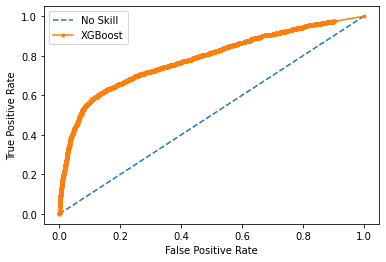

In [47]:
# predict probabilities
xgb_probs = model.predict_proba(X_test)
xgb_probs = xgb_probs[:, 1] #probabilities for the positive outcome only

# calculate scores
xgb_auc = roc_auc_score(y_test, xgb_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (xgb_auc))

# calculate roc curves
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, rf_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.savefig('image/_7_base-xgb.png',bbox_inches = 'tight')
plt.show()

### XG Boost

xgb = XGBClassifier(verbosity = 0) # verbosity = 0 : to hide warnings

params = {
    'max_depth': [6, 9, 11, 13, 16, 19, 22], 
    'n_estimators': [100],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid_xgb = GridSearchCV(xgb, param_grid=params, cv = kfolds)
grid_xgb.fit(X_train, y_train)

print(grid_xgb.best_score_)
print(grid_xgb.best_params_)

### 5-5. Comparing Models

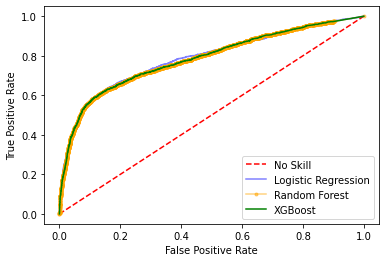

In [48]:
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill',color='red')
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression', color='blue',alpha=0.5)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest',color='orange',alpha=0.5)
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('image/_8_base-comparison.png',bbox_inches = 'tight')
plt.show()

In [49]:
results = results.set_index('Model')

## 6. Over sampling using SMOTE
- Synthetic Minority Oversampling Technique (SMOTE) algorithm 
    - Creates synthetic samples from the minor class

In [50]:
df['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [51]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = seed)
X_smote,y_smote = smote.fit_resample(X_train,y_train)

# length of oversampled data
print(X_smote.shape,y_smote.shape)
print(len(X_smote),len(y_smote))
print(len(y_smote[y_smote==0]),len(y_smote[y_smote ==1]))

(51174, 40) (51174,)
51174 51174
25587 25587


Now, the target, y, is blanced.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.3 ,random_state = seed)

### 6-1) SMOTE and Logistic Regression

In [53]:
# scale the data
scaler = MinMaxScaler() #since the data is not normally distributed (less influenced by outliers)
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [74]:
model = LogisticRegression(random_state=seed)
model.fit(X_train_s,y_train)
yhat=model.predict(X_test_s)

In [75]:
results = results.append(Evaluationmatrix_dict(y_test,yhat,name="LR_smote"),ignore_index = True)

In [76]:
print(confusion_matrix(y_test,yhat))
print('Accuracy Score:', round(accuracy_score(y_test,yhat),2))
print('Precision Score:', round(precision_score(y_test,yhat),2))
print('Recall Score:', round(recall_score(y_test,yhat),2))
#print('CV Score:', round(cross_val_score(model, X_train_s, y_train, cv=kfolds, n_jobs=1, scoring = 'accuracy').mean(),2))

[[6875  779]
 [1125 6574]]
Accuracy Score: 0.88
Precision Score: 0.89
Recall Score: 0.85


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.938


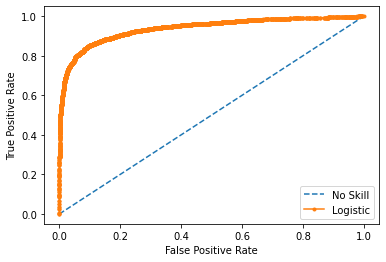

In [77]:
# no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = model.predict_proba(X_test_s)
lr_probs = lr_probs[:, 1] #probabilities for the positive outcome only

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('image/_9_SMoTE-LR.png',bbox_inches = 'tight')
plt.show()

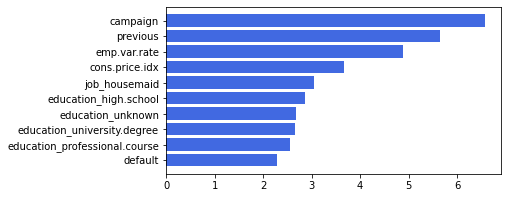

In [78]:
coefs = np.abs(model.coef_[0])

indices = np.argsort(coefs)[::-1]
plt.figure()
#plt.title("Feature importances - Logistic Regression")
plt.barh(range(10), coefs[indices[:10]],
       color="#4169e1", align="center")
plt.yticks(range(10), X.columns[indices[:10]], ha='right')
plt.subplots_adjust(bottom=0.3)
plt.gca().invert_yaxis()
plt.savefig('image/_10_SMoTE-LR-FI.png',bbox_inches = 'tight')

In [79]:
model.coef_[0,indices]

array([-6.57175275, -5.63785202, -4.87986663,  3.66534845, -3.04236988,
       -2.86693292, -2.68450961, -2.65308567, -2.54487433,  2.27611915,
       -2.18703726, -2.15948357,  2.13283564, -1.91440463, -1.87867073,
       -1.85654084, -1.83848463, -1.79849339, -1.76582288, -1.69083362,
       -1.64809754, -1.63065703, -1.60449482, -1.5098431 , -1.47190271,
       -1.45009487, -1.42318503, -1.40435515, -1.22582157, -1.1922584 ,
        1.07387816, -1.03223588, -1.00431599, -0.91207658, -0.88369094,
       -0.86540651, -0.79922869, -0.75988322,  0.70585867, -0.67758477])

In [72]:
coefs[indices[:10]]

array([6.57175275, 5.63785202, 4.87986663, 3.66534845, 3.04236988,
       2.86693292, 2.68450961, 2.65308567, 2.54487433, 2.27611915])

### 6-2) SMOTE and Random Forest Classifier

In [59]:
model = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10, random_state=seed)
model.fit(X_train, y_train)
yhat=model.predict(X_test)

In [60]:
results = results.append(Evaluationmatrix_dict(y_test,yhat,name="RF_smote"),ignore_index = True)

In [61]:
print(confusion_matrix(y_test,yhat))
print('Accuracy Score:', round(accuracy_score(y_test,yhat),2))
print('Precision Score:', round(precision_score(y_test,yhat),2))
print('Recall Score:', round(recall_score(y_test,yhat),2))
#print('CV Score:', round(cross_val_score(model, X_train, y_train, cv=kfolds, n_jobs=1, scoring = 'accuracy').mean(),2))

[[7118  536]
 [ 747 6952]]
Accuracy Score: 0.92
Precision Score: 0.93
Recall Score: 0.9


No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.969


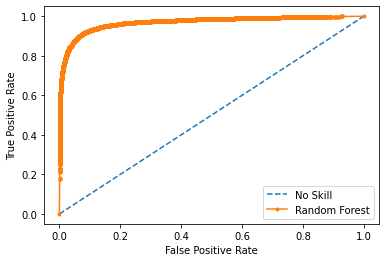

In [62]:
# predict probabilities
rf_probs = model.predict_proba(X_test)
rf_probs = rf_probs[:, 1] #probabilities for the positive outcome only

# calculate scores
rf_auc = roc_auc_score(y_test, rf_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))

# calculate roc curves
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.savefig('image/_11_SMOTE-RF.png',bbox_inches = 'tight')
plt.show()

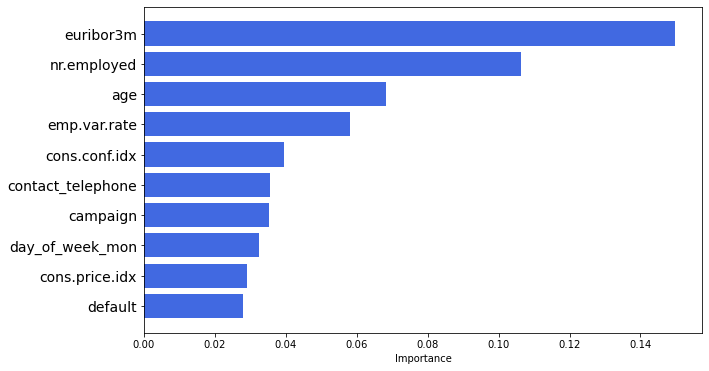

In [63]:
feature_names = X_train.columns
feature_imports = model.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', color="#4169e1")
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
#plt.title('Most important features - Random Forest ')
plt.savefig('image/_12_SMOTE-RF-FI.png',bbox_inches = 'tight')
plt.show()

### 6-3) SMOTE and XGBoost

In [64]:
model = XGBClassifier()
model.fit(X_train, y_train)
yhat = model.predict(X_test)

In [65]:
results = results.append(Evaluationmatrix_dict(y_test,yhat,name="XGB_smote"),ignore_index = True)

In [66]:
print(confusion_matrix(y_test,yhat))
print('Accuracy Score:', round(accuracy_score(y_test,yhat),2))
print('Precision Score:', round(precision_score(y_test,yhat),2))
print('Recall Score:', round(recall_score(y_test,yhat),2))
#print('CV Score:', round(cross_val_score(model, X_train, y_train, cv=kfolds, n_jobs=1, scoring = 'accuracy').mean(),2))

[[7232  422]
 [ 685 7014]]
Accuracy Score: 0.93
Precision Score: 0.94
Recall Score: 0.91


No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.971


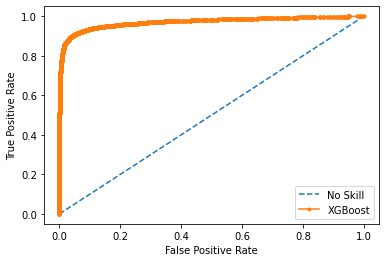

In [67]:
# predict probabilities
xgb_probs = model.predict_proba(X_test)
xgb_probs = xgb_probs[:, 1] #probabilities for the positive outcome only

# calculate scores
xgb_auc = roc_auc_score(y_test, xgb_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (xgb_auc))

# calculate roc curves
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.savefig('image/_13_SMOTE-XGB-FI.png',bbox_inches = 'tight')
plt.show()

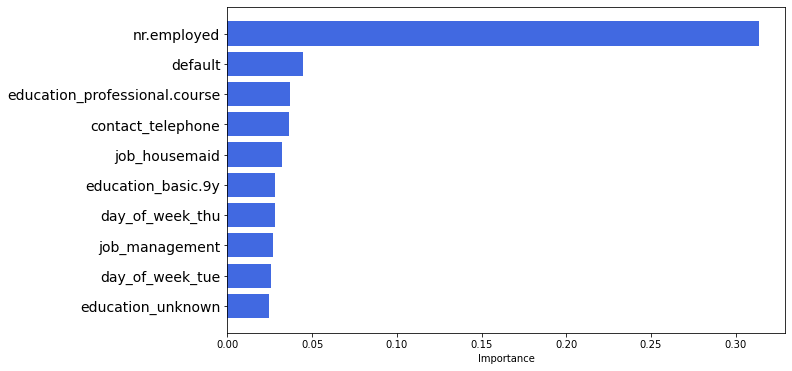

In [68]:
feature_names = X_train.columns
feature_imports = model.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', color="#4169e1")
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
#plt.title('Most important features - XGBoost')

plt.savefig('image/_14_SMOTE-XGB-FI.png',bbox_inches = 'tight')
plt.show()

### 6-4) Comparing Models

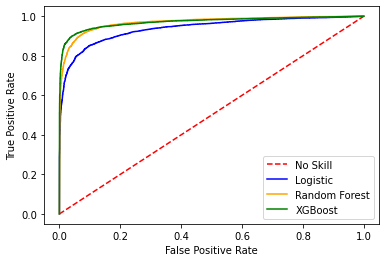

In [69]:
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', color='red')
plt.plot(lr_fpr, lr_tpr, label='Logistic', color='blue')
plt.plot(rf_fpr, rf_tpr, label='Random Forest',color='orange')
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('image/_15_ModelComparison.png',bbox_inches = 'tight')
plt.show()

In [70]:
results = results.set_index('Model')

In [71]:
results

,Accuracy Score,CV Score,F1 Score,Precision Score,ROC AUC,Recall Score
Model,,,,,,
NaN,0.901,0.899,0.335,0.697,0.604,0.221
NaN,0.898,0.896,0.400,0.601,0.637,0.300
NaN,0.896,0.898,0.390,0.575,0.634,0.295
LR_smote,0.876,0.899,0.874,0.894,0.876,0.854
RF_smote,0.916,0.896,0.916,0.928,0.916,0.903
XGB_smote,0.928,0.898,0.927,0.943,0.928,0.911


weighted accuracy - 
probability threshold - dangerous
roc curve
lift 
choose the probability 